# $B$ peak reconstruction for $B^0 \to K^* \tau \tau$ using $\tau \to 3\pi \nu$

This method uses the maximum opening angle between the $3\pi$ momentum and the $\tau$ flight in order to estimate the $\tau$ momentum, as used in the hadronic $R(D^*)$ measurements. Perfect detector performance is assumed on all input quantities, so resolution effects appear purely due to the $\tau$ momentum estimates. 

In [1]:
import sys, os
import uproot4 as uproot
import numpy as np
import matplotlib.pyplot as plt
import json
from particle import literals as lp

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Load ROOT file using `uproot`

In [2]:
file = uproot.open("../data/model_tree.root")
tree = file['DecayTree']

Load into `pandas` DataFrame

In [3]:
df = tree.arrays(library="pd")

$B$ and $\tau$ flight using true vertex positions:

In [4]:
for comp in ["x","y","z"]:
    for p in ["B","Tau_1","Tau_2"]:
        df[f"{p}_FD_{comp}"] = df[f"{p}_End_{comp}_TRUE"] - df[f"{p}_Ori_{comp}_TRUE"]
for p in ["B","Tau_1","Tau_2"]:
    df[f"{p}_FD"] = np.sqrt(df[f"{p}_FD_x"]**2 + df[f"{p}_FD_y"]**2 + df[f"{p}_FD_z"]**2)

PDG mass of $\tau$

In [5]:
Tau_M = lp.tau_plus.mass/1000.

$3\pi$ system quantities at truth-level, to use in the $\tau$ reconstruction

In [6]:
for comp in ["PX","PY","PZ","E"]:
    for t in ["1","2"]:
        df[f"3pi_{t}_{comp}_TRUE"] = df[f"Tau_{t}_Pi_1_{comp}_TRUE"] + df[f"Tau_{t}_Pi_2_{comp}_TRUE"] + df[f"Tau_{t}_Pi_3_{comp}_TRUE"]
for t in ["1","2"]:
    df[f"3pi_{t}_P_TRUE"] = np.sqrt(df[f"3pi_{t}_PX_TRUE"]**2 + df[f"3pi_{t}_PY_TRUE"]**2 + df[f"3pi_{t}_PZ_TRUE"]**2)
    df[f"3pi_{t}_M_TRUE"] = np.sqrt(df[f"3pi_{t}_E_TRUE"]**2 - df[f"3pi_{t}_P_TRUE"]**2)

Maximum angle of the $3\pi$ momenta compared to $\tau$ flight

In [7]:
for t in ["1","2"]:
    df[f"Tau_{t}_angle_max"] = np.arcsin((Tau_M**2 - df[f"3pi_{t}_M_TRUE"]**2)/(2.*Tau_M*df[f"3pi_{t}_P_TRUE"]))

/Users/dhill/miniconda/envs/PyEnv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in arcsin
  result = getattr(ufunc, method)(*inputs, **kwargs)


$\tau$ momentum solutions corresponding to maximum angle:

In [8]:
for t in ["1","2"]:
    df[f"Tau_{t}_P_reco"] = ((df[f"3pi_{t}_M_TRUE"]**2 + Tau_M**2)*df[f"3pi_{t}_P_TRUE"]*np.cos(df[f"Tau_{t}_angle_max"]))/(2.*(df[f"3pi_{t}_E_TRUE"]**2 - df[f"3pi_{t}_P_TRUE"]**2*(np.cos(df[f"Tau_{t}_angle_max"]))**2))
    df[f"Tau_{t}_E_reco"] = np.sqrt(df[f"Tau_{t}_P_reco"]**2 + Tau_M**2)
    

$\tau$ momentum components using flight vector

In [9]:
for t in ["1","2"]:
    for comp in ["x","y","z"]:
        df[f"Tau_{t}_P{comp.upper()}_reco"] = df[f"Tau_{t}_P_reco"] * (df[f"Tau_{t}_FD_{comp}"]/df[f"Tau_{t}_FD"])

$B$ quantities based on measured $K^*$ and estimated $\tau$

In [10]:
for comp in ["PX","PY","PZ","E"]:
    df[f"B_{comp}_reco"] = df[f"Kst_{comp}_TRUE"] + df[f"Tau_1_{comp}_reco"] + df[f"Tau_2_{comp}_reco"]
df["B_P_reco"] = np.sqrt(df["B_PX_reco"]**2 + df["B_PY_reco"]**2 + df["B_PZ_reco"]**2)
df["B_M_reco"] = np.sqrt(df["B_E_reco"]**2 - df["B_P_reco"]**2)
df["B_PX_reco_2"] = df["B_P_reco"] * (df["B_FD_x"]/df["B_FD"])
mu = df["B_M_reco"].mean()
sigma = df["B_M_reco"].std()

Plot the reconstructed $B$ mass:

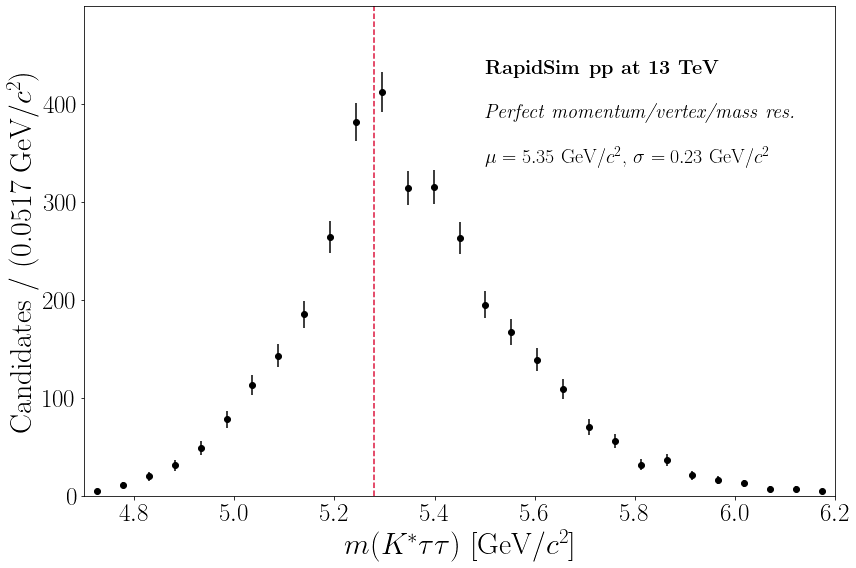

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
n = len(df)
bins = int(0.5*np.sqrt(n))
low = 4.7
high = 6.2
bin_w = (high - low)/bins
units = "GeV/$c^2$"

counts, bin_edges = np.histogram(df["B_M_reco"], bins, range=(low,high))
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = np.sqrt(counts)
plt.errorbar(bin_centres, counts, yerr=err, fmt='o', color='k')
plt.xlabel(f"$m(K^* \\tau \\tau)$ [{units}]",fontsize=30)
plt.ylabel("Candidates / (%.4f %s)" % (bin_w, units), fontsize=30)
plt.xlim(low,high)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.axvline(lp.B_plus.mass/1000.,color='crimson',linestyle='--')
ymin, ymax = plt.ylim()
plt.ylim(0.,ymax*1.1)
plt.text(high-0.7,0.95*ymax,"\\textbf{RapidSim pp at 13 TeV}",fontsize=20)
plt.text(high-0.7,0.85*ymax,"\\textit{Perfect momentum/vertex/mass res.}",fontsize=20)
plt.text(high-0.7,0.75*ymax,f"$\\mu = {mu:.2f}$ {units}, $\sigma = {sigma:.2f}$ {units}",fontsize=20)
plt.tight_layout()
plt.show()
fig.savefig("../plots/M_KstTauTau_reco.pdf")